In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

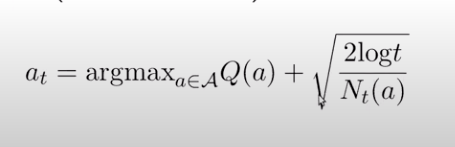

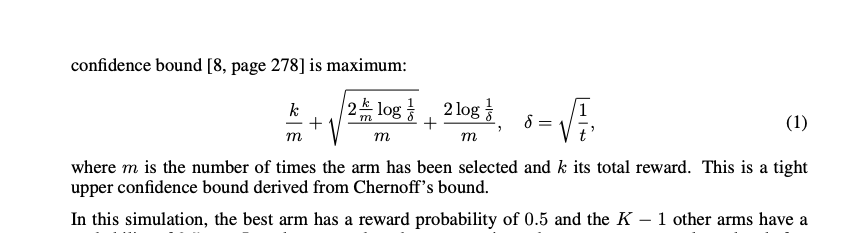

In [13]:
class ThompsonVsUCB:

    def __init__(self):
        # immutable params:
        self.E = [0.1, 0.02]
        self.best_one = 0.5
        self.K = [10]
        self.a = 1
        self.b = 1
        self.speeding_factor = 100
        self.iterations = 1000000
        self.algos = ['thompson', 'ucb']
        self.results_dict = {f'{algo}_regrets_e_{e}_k_{k}': [] for e in self.E for k in self.K for algo in self.algos}
        
    def get_uncertainty(self, action, i, m):
        # Uncertainty term for the ucb:
        delta = np.sqrt(1/(i+1))
        uncertainty = np.sqrt((2 * action * np.log(1/delta)) / m) + (2*np.log(1/delta)) / m
        if m == 0:
            uncertainty = np.inf
        return uncertainty

    def get_cum_regret(self, S, F, true_probs):
        # Cumulative regrets:
        N = S + F
        delta = [0.5 - t for t in true_probs]
        cum_regret = np.dot(N, delta)
        return cum_regret, N

    def get_thetas(self, S, F, K):
        return [np.random.beta(self.a + S[j], self.b + F[j]) for j in range(K)]

    def algorithm(self, t, S, F, N, K, true_probs, alg='thompson'):

        # compute probabilities:
        thetas = self.get_thetas(S, F, K)

        # choose action thompson:
        if alg=='thompson':
            choice_index = np.argmax(thetas)

        # choose action ucb:
        elif alg=='ucb':
            uncertainties = [self.get_uncertainty(thetas[j], t, N[j]) for j in range(K)]
            ucb = [x + y for x, y in zip(thetas, uncertainties)]
            choice_index = np.argmax(ucb)

        # compute reward and update S and F:
        outcome = np.random.binomial(size=1, n=1, p=true_probs[choice_index])
        S[choice_index] += outcome
        F[choice_index] += 1 - outcome

        # cumulative regret:
        cum_regret, N = self.get_cum_regret(S, F, true_probs)

        return cum_regret, N, S, F

    def alb(self, K, e, t):

        delta_a = self.best_one - e
        b = self.best_one
        alb = (K - 1) * (b - delta_a) / ((1 - delta_a) * np.log((1 - delta_a)/(1 - b)) + (delta_a * np.log(delta_a / b)))

        al_bound = np.log(np.arange(0, t)) * alb
        return al_bound

    def kl_divergence(self, d1, d2):
        return d1 * np.log(d1/d2) + (1-d1) * np.log((1-d1)/(1-d2))

    def main(self):

        # load immutable settings:
        E = self.E
        best_one = self.best_one
        K = self.K
        a = self.a
        b = self.b
        speeding_factor = self.speeding_factor
        iterations = self.iterations
        
        # iterate over different settings of epsilon and K:
        for i, e in enumerate(E):
            for j, k in enumerate(K):
                
                # mutable settings:
                cum_regrets_tho = []
                cum_regrets_ucb = []
                N_thompson = np.zeros(k)
                N_ucb = np.zeros(k)
                S_thompson = np.zeros(k)
                S_ucb = np.zeros(k)
                F_thompson = np.zeros(k)
                F_ucb = np.zeros(k)
                true_probs = [0.5 if n==0 else best_one - e for n in range(k)]
                
                # iterate over time periods:
                for t in range(iterations):
                    if t%(1000*speeding_factor)==0:
                        print(f't:{t}')
                    # compute cumulative regret of thompson sampling:
                    thompson_regret, N_thompson, S_thompson, F_thompson = self.algorithm(t, S_thompson, F_thompson, N_thompson, k, true_probs, alg='thompson')

                    # compute cumulative regret of ucb method:
                    ucb_regret, N_ucb, S_ucb, F_ucb = self.algorithm(t, S_ucb, F_ucb, N_ucb, k, true_probs, alg='ucb')

                    # append results (only every 100 steps to save memory):
                    if t%speeding_factor == 0:
                        cum_regrets_ucb.append(ucb_regret)
                        cum_regrets_tho.append(thompson_regret)
                
                # store results:
                self.results_dict[f'thompson_regrets_e_{e}_k_{k}'].append(cum_regrets_tho)
                self.results_dict[f'ucb_regrets_e_{e}_k_{k}'].append(cum_regrets_ucb)
                
                # compute and store asymptotic lower bound:
                as_lower_bound = [t for i, t in enumerate(self.alb(10, 0.1, iterations)) if i%speeding_factor==0]
                as_lower_bound = [b - as_lower_bound[1] for b in as_lower_bound]
                self.results_dict[f'as_lower_bound_e_{e}_k_{k}'] = as_lower_bound

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log
/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log


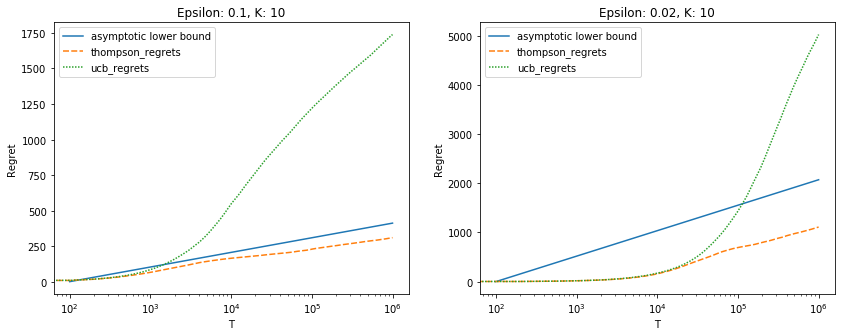

CPU times: user 10.4 s, sys: 155 ms, total: 10.6 s
Wall time: 11.1 s


In [14]:
%%time
simon = ThompsonVsUCB()
for i in range(10):
    print(f'iteration: {i+1}/10')
    simon.main()

# define plots: 
f, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_x_range = [simon.speeding_factor * n for n in range(int((simon.iterations)/simon.speeding_factor))]

for i, e in enumerate(simon.E):
    for j, k in enumerate(simon.K):
        
        df = pd.DataFrame(index=plot_x_range)
        
        as_lower_bound = [t for i, t in enumerate(simon.alb(k, e, simon.iterations)) if i%simon.speeding_factor==0]
        as_lower_bound = [b - as_lower_bound[1] for b in as_lower_bound]
        df['asymptotic lower bound'] = as_lower_bound
        for algo in simon.algos:
            df[f'{algo}_regrets'] = np.mean(simon.results_dict[f'{algo}_regrets_e_{e}_k_{k}'], axis=0)

        # draw plots:
        axes[i].set(xscale="log", xlabel='T', ylabel='Regret')
        sns.lineplot(data=df, ax=axes[i], legend='full')
        axes[i].set_title(f'Epsilon: {e}, K: {k}')
plt.savefig('figure.pdf')
plt.show()